In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
import geopandas as gpd
import seaborn as sns
import xarray as xr
import pandas as pd
import glob
import os
from scipy.stats import linregress

In [3]:
#Output Folders
folder = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/'
S2_path = folder + 'S2B_MSIL2A_20230911T170859_N0509_R112_T15TUJ_20230911T214609.SAFE/S2B_MSIL2A_20230911T170859_N0509_R112_T15TUJ_20230911T214609.SAFE/GRANULE/L2A_T15TUJ_A034029_20230911T171258/IMG_DATA/R20m/'
BSL = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/big_spirit_lake.shp'
output = folder + 'GP_GP_Final/'
S2_idw = output + 'S2_idw.tif'
#Sentinel bands to pull
S2_bands = ['B04', 'B05']

In [4]:
def SENT_NDCI(dir,
             shape,
              bands,
             plot = False,
             save = False):
    
    SP = gpd.read_file(shape)
    shape = SP.to_crs(32615)
    red_path = glob.glob(dir + f'/*{bands[0]}*')
    red = rxr.open_rasterio(red_path[0], masked=True)
    
    red_edge_path = glob.glob(dir + f'/*{bands[1]}*')
    red_edge = rxr.open_rasterio(red_edge_path[0], masked=True)
    
    
    clipped_red = red.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    clipped_red_edge = red_edge.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False) 
    
    NDCI = (clipped_red_edge - clipped_red) / (clipped_red_edge + clipped_red) 
    if plot == True:
        NDCI.plot(
            cmap = 'gnuplot',
            vmin = .05,
            vmax = .09)
        plt.title(f"Sentinel-2 NDCI")
   
    if save == True:
        outname = "Sentinel-2_BSL_NDCI.tif"
        NDCI.rio.to_raster(os.path.join(output, outname), driver='GTIFF')
    
    return NDCI

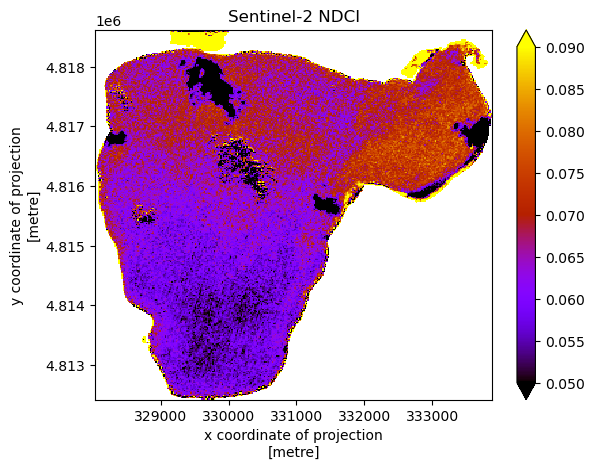

In [5]:
NDCI = SENT_NDCI(S2_path,
                   BSL,
                   S2_bands,
                   True,
                   False)

In [6]:
def normalize(array):
        """Normalizes numpy arrays into scale 0.0 - 1.0"""
        array_min, array_max = array.min(), array.max()
        return ((array - array_min)/(array_max - array_min))

NDCI_flat = NDCI.values.flatten()
NDCI_flat = NDCI_flat[~np.isnan(NDCI_flat)]
NDCI_filtered = NDCI_flat[(NDCI_flat >= -1) & (NDCI_flat <= 1)]
NDCI_norm = normalize(NDCI_flat)
NDCI_norm

array([0.4577044 , 0.49766606, 0.59446675, ..., 0.2986988 , 0.3659392 ,
       0.49094942], dtype=float32)

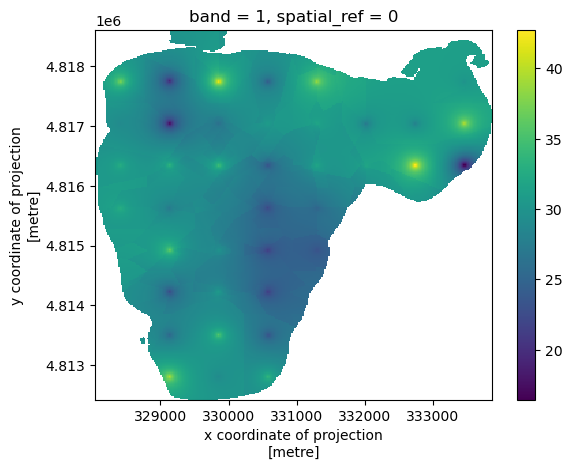

In [7]:
idw = rxr.open_rasterio(S2_idw)
shapei = gpd.read_file(BSL)
shape = shapei.to_crs(32615)
clipped_idw = idw.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
clipped_idw.squeeze().plot.imshow(interpolation='none')

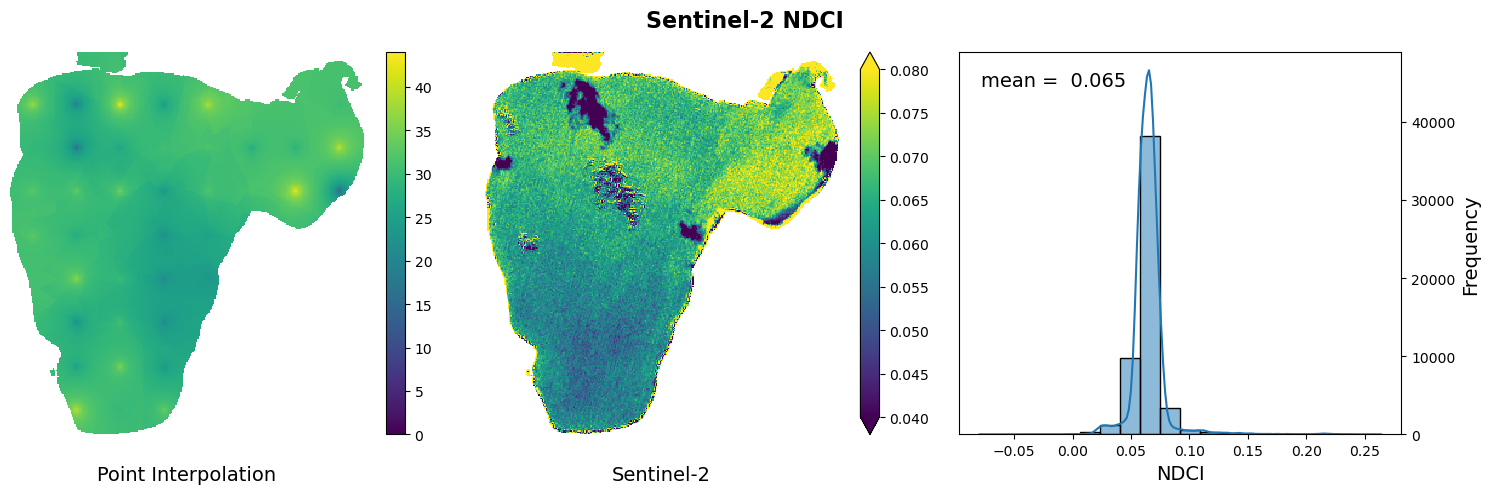

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,5))
mean = np.mean(NDCI_flat)   
a = NDCI 
b = clipped_idw

b.squeeze().plot.imshow(cmap = 'viridis', 
                        vmax=44, 
                        vmin=0, 
                        ax=ax0)
ax0.axis('off')
ax0.set_title("Point Interpolation", y=0, pad=-22, verticalalignment="top", fontsize=14)

a.squeeze().plot.imshow(cmap = 'viridis',
              vmax =.08, 
              vmin = .04, 
              ax=ax1)
ax1.axis('off')
ax1.set_title("Sentinel-2", y=0, pad=-22, verticalalignment="top", fontsize=14)
sns.histplot(NDCI_flat, 
                 kde=True, 
                 bins=20,
                 ax=ax2)
ax2.set_xlabel('NDCI', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.text(.05, .95, f'mean = {mean: .3f}', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
   
    
fig.suptitle(f'Sentinel-2 NDCI', fontsize=16, fontweight = 'bold')
plt.tight_layout()
#plt.savefig(os.path.join(output, f'Sentinel-2_NDCI_fig'), dpi=1200, bbox_inches='tight')
plt.show()

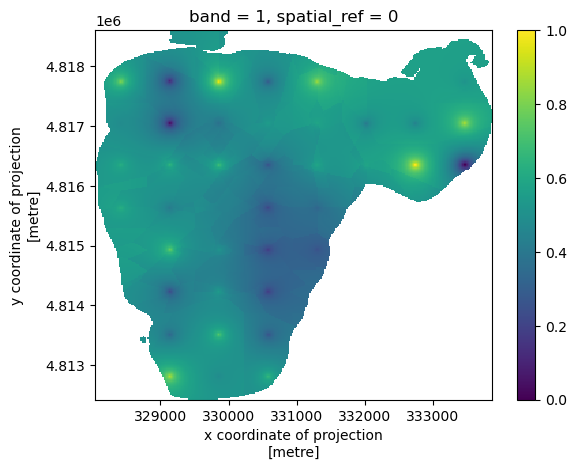

In [14]:
ras_norm = normalize(NDCI)
idw_norm = normalize(clipped_idw)

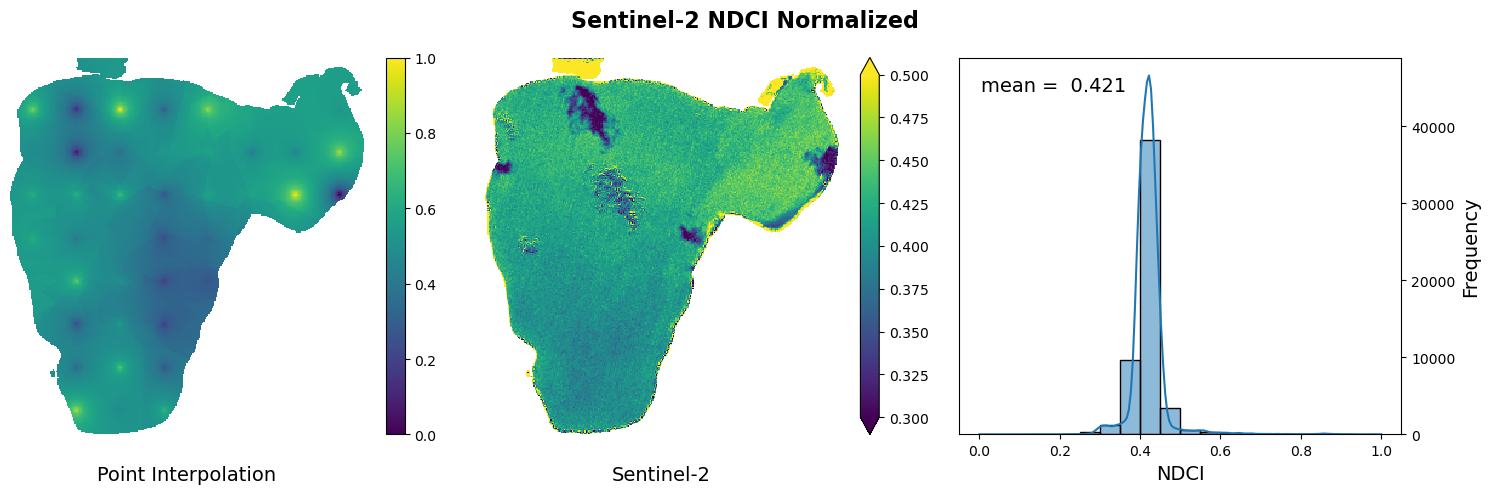

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,5))
mean = np.mean(NDCI_norm)   
a = ras_norm 
b = idw_norm

b.squeeze().plot.imshow(cmap = 'viridis',
                        ax=ax0)
ax0.axis('off')
ax0.set_title("Point Interpolation", y=0, pad=-22, verticalalignment="top", fontsize=14)

a.squeeze().plot.imshow(cmap = 'viridis',
              vmax =.5, 
              vmin = .3, 
              ax=ax1)
ax1.axis('off')
ax1.set_title("Sentinel-2", y=0, pad=-22, verticalalignment="top", fontsize=14)
sns.histplot(NDCI_norm, 
                 kde=True, 
                 bins=20,
                 ax=ax2)
ax2.set_xlabel('NDCI', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.text(.05, .95, f'mean = {mean: .3f}', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
   
    
fig.suptitle(f'Sentinel-2 NDCI Normalized', fontsize=16, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(output, f'Sentinel-2_NDCI_fig_normalized'), dpi=1200, bbox_inches='tight')
plt.show()